In [62]:
#LINK:   https://www.analyticsvidhya.com/blog/2022/03/music-genre-classification-project-using-machine-learning-techniques/

In [63]:
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav

In [64]:
from python_speech_features import mfcc
from tempfile import TemporaryFile
import os
import math
import pickle
import random
import operator

In [65]:
df=pd.read_csv("C:/Users/HP/Desktop/ANJU/Sem 8/Mini Project/dataset/Data/features_3_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [66]:
df.shape

(9990, 60)

In [67]:
print("Columns containing missing values",list(df.columns[df.isnull().any()]))

Columns containing missing values []


In [68]:
#define a function to get distance between feature vectors and find neighbors
def getNeighbors(trainingset, instance, k):
    distances = []
    for x in range(len(trainingset)):
        dist = distance(trainingset[x], instance, k) + distance(instance,trainingset[x],k)
        distances.append((trainingset[x][2], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors


In [69]:
#function to identify the nearest neighbors
def nearestclass(neighbors):
    classVote = {}
    
    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1
            
    sorter = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    return sorter[0][0]

In [70]:
def getAccuracy(testSet, prediction):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == prediction[x]:
            correct += 1
    return 1.0 * correct / len(testSet)

In [71]:
directory = 'C:/Users/HP/Desktop/ANJU/Sem 8/Mini Project/dataset/Data/genres_original'
f = open("mydataset.dat", "wb")
i = 0
for folder in os.listdir(directory):
    #print(folder)
    i += 1
    if i == 11:
        break
    for file in os.listdir(directory+"/"+folder):
        #print(file)
        try:
            (rate, sig) = wav.read(directory+"/"+folder+"/"+file)
            mfcc_feat = mfcc(sig, rate, winlen = 0.020, appendEnergy=False)
            covariance = np.cov(np.matrix.transpose(mfcc_feat))
            mean_matrix = mfcc_feat.mean(0)
            feature = (mean_matrix, covariance, i)
            pickle.dump(feature, f)
        except Exception as e:
            print("Got an exception: ", e, 'in folder: ', folder, ' filename: ', file)
f.close()

Got an exception:  File format b'\xcb\x15\x1e\x16' not understood. Only 'RIFF' and 'RIFX' supported. in folder:  jazz  filename:  jazz.00054.wav


In [72]:
dataset = []

def loadDataset(filename, split, trset, teset):
    with open('mydataset.dat','rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    for x in range(len(dataset)):
        if random.random() < split:
            trset.append(dataset[x])
        else:
            teset.append(dataset[x])

trainingSet = []
testSet = []
loadDataset('my.dat', 0.8, trainingSet, testSet)

In [73]:
def distance(instance1, instance2, k):
    distance = 0
    mm1 = instance1[0]
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    distance += (np.dot(np.dot((mm2-mm1).transpose(), np.linalg.inv(cm2)), mm2-mm1))
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k
    return distance

In [74]:
# Make the prediction using KNN(K nearest Neighbors)
length = len(testSet)
predictions = []
for x in range(length):
    predictions.append(nearestclass(getNeighbors(trainingSet, testSet[x], 5)))

accuracy1 = getAccuracy(testSet, predictions)
print(accuracy1)

0.7029702970297029


In [75]:
from collections import defaultdict
results = defaultdict(int)

directory = "C:/Users/HP/Desktop/ANJU/Sem 8/Mini Project/dataset/Data/genres_original"

i = 1
for folder in os.listdir(directory):
    results[i] = folder
    i += 1

In [76]:
pred=nearestclass(getNeighbors(dataset,feature,5))
print("Genre: ",results[pred])

Genre:  rock


In [18]:
#SVM

In [16]:
#https://www.kaggle.com/code/sunilxd/song-classification-using-svm

In [17]:
## packages

import librosa
import sklearn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

import os

import numpy as np
import pandas as pd

In [19]:
## testing with a file

audio_path = 'C:/Users/HP/Desktop/ANJU/Sem 8/Mini Project/dataset/Data/genres_original/reggae/reggae.00003.wav'
x , sr = librosa.load(audio_path)
print(type(x), type(sr))

print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050


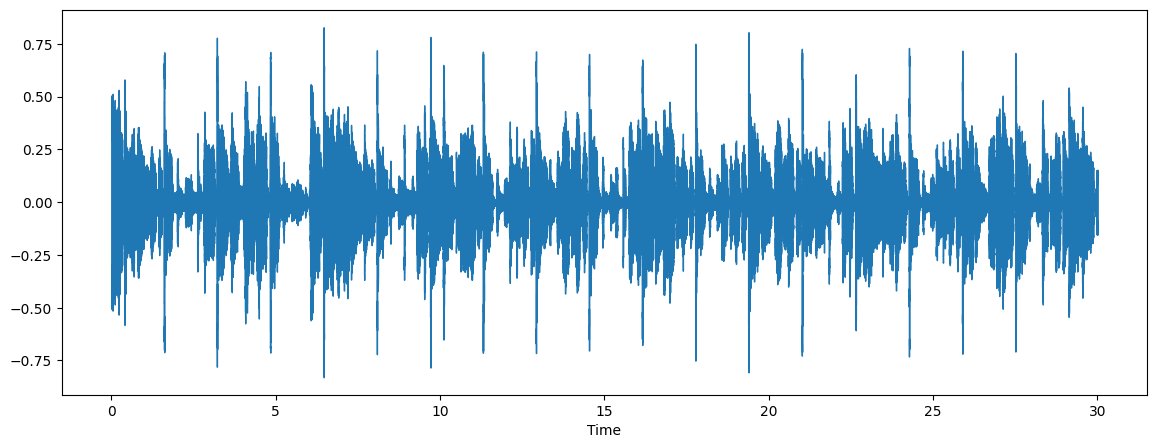

In [20]:
## ploting the file in waveform

plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

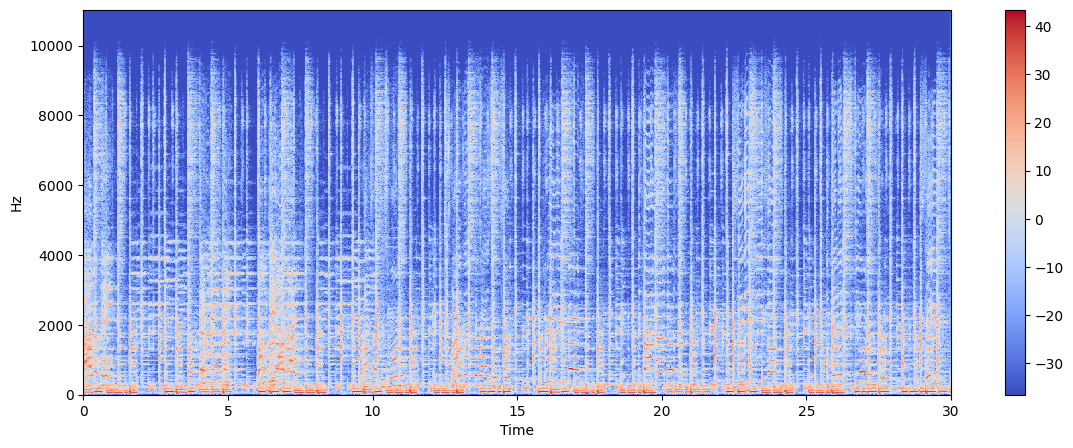

In [21]:
## converting the song into image using Spectrogram

X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

5


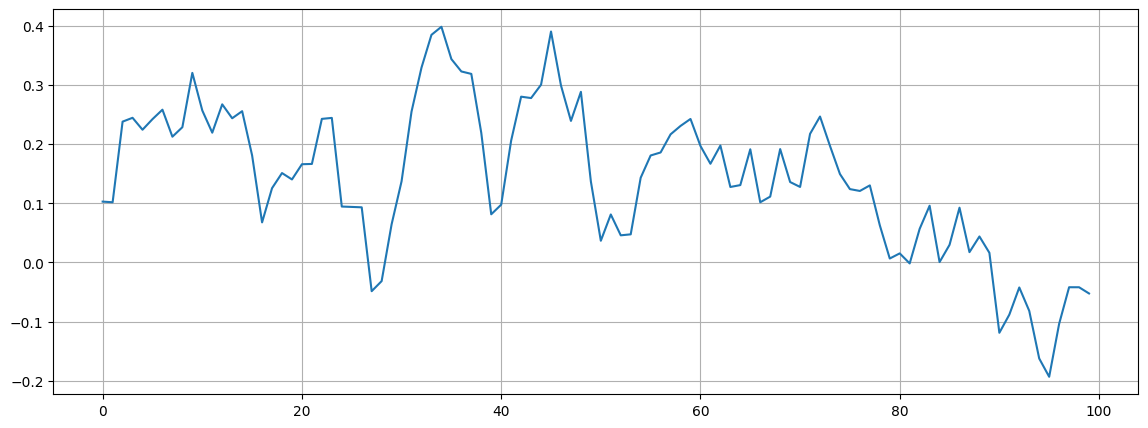

In [22]:
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

In [77]:
genre = ['hiphop', 'pop']

In [99]:
## feature extraction funciton

def normalize(x, axis=0):
        return sklearn.preprocessing.minmax_scale(x, axis=axis)

def zero_cross(x):
    n0 = 9000
    n1 = 9100
    zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
    return sum(zero_crossings)

def spec_center(x, sr):
    spectral_centroids = normalize(librosa.feature.spectral_centroid(x, sr)[0])
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    ma = max(spectral_centroids)
    return t[np.where(spectral_centroids==ma)[0][0]]

In [103]:
li = []
path = 'C:/Users/HP/Desktop/ANJU/Sem 8/Mini Project/dataset/Data/genres_original/'

for gen in genre:
    for song in os.listdir(os.path.join(path, gen)):
        x, sr = librosa.load(os.path.join(path, gen, song))
        li.append([zero_cross(x), round(spec_center(x,sr))])

TypeError: spectral_centroid() takes 0 positional arguments but 2 were given

In [32]:
#Implementing svm

In [81]:
df = pd.read_csv("C:/Users/HP/Desktop/ANJU/Sem 8/Mini Project/dataset/Data/features_3_sec.csv")
df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


In [104]:
from sklearn.preprocessing import LabelEncoder
# Label Encoding - encod the categorical classes with numerical integer values for training

# Blues - 0
# Classical - 1
# Country - 2
# Disco - 3
# Hip-hop - 4 
# Jazz - 5  
# Metal - 6 
# Pop - 7
# Reggae - 8
# Rock - 9

class_encod=df.iloc[:,-1]
converter=LabelEncoder()
y=converter.fit_transform(class_encod)
y

array([0, 0, 0, ..., 9, 9, 9])

In [105]:
df=df.drop(labels="filename",axis=1)

In [106]:
from sklearn.preprocessing import StandardScaler
fit=StandardScaler()
X=fit.fit_transform(np.array(df.iloc[:,:-1],dtype=float))

In [107]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [108]:
from sklearn.svm import SVC
classifier = SVC(kernel='rbf', random_state = 1)
classifier.fit(X_train,y_train)

SVC(random_state=1)

In [109]:
y_pred = classifier.predict(X_test)

In [110]:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[188,   1,   3,   2,   0,   3,   6,   0,   0,   1],
       [  0, 199,   2,   0,   0,   4,   0,   0,   0,   1],
       [  6,   1, 177,   2,   2,  11,   0,   3,   2,  11],
       [  2,   2,   2, 149,   2,   0,   1,   4,   5,   9],
       [  5,   1,   3,   6, 166,   0,   6,   6,  17,   2],
       [  1,   8,   5,   2,   0, 178,   0,   0,   0,   0],
       [  3,   1,   0,   5,   0,   0, 205,   0,   1,   3],
       [  0,   4,   4,  11,   1,   0,   0, 169,   4,   3],
       [  5,   1,   5,   6,   2,   3,   2,   3, 163,   9],
       [  4,   4,   6,  15,   2,   7,   6,   1,   2, 131]], dtype=int64)

In [111]:
## testing for custom song

pa = 'C:/Users/HP/Desktop/ANJU/Sem 8/Mini Project/dataset/Data/genres_original/hiphop/hiphop.00004.wav'
x, sr = librosa.load(pa)
print(classifier.predict(np.array([[zero_cross(x), round(spec_center(x, sr), 2)]])))

TypeError: spectral_centroid() takes 0 positional arguments but 2 were given

In [55]:
pa = 'C:/Users/HP/Desktop/ANJU/Sem 8/Mini Project/dataset/Data/genres_original/hiphop/hiphop.00004.wav'
x, sr = librosa.load(pa)
centroid = librosa.feature.spectral_centroid(x, sr=sr)
print(classifier.predict(np.array([[zero_cross(x), round(centroid[0][0], 2)]])))


TypeError: spectral_centroid() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given

In [59]:
import librosa
import numpy as np
pa = 'C:/Users/HP/Desktop/ANJU/Sem 8/Mini Project/dataset/Data/genres_original/hiphop/hiphop.00004.wav'
x, sr = librosa.load(pa)
centroid = librosa.feature.spectral_centroid(x, sr=sr)[0]
print(classifier.predict(np.array([[zero_cross(x), round(centroid[0], 2)]])))



TypeError: spectral_centroid() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given

In [60]:
from itertools import combinations
from sklearn.metrics import accuracy_score

def accuracy(genre):
    li = []
    for gen in genre:
        for song in os.listdir(os.path.join(path, gen)):
            x, sr = librosa.load(os.path.join(path, gen, song))
            li.append([zero_cross(x), round(spec_center(x, sr), 2), gen])
    li = np.array(li)
    X = li[:, 0:2]
    y = li[:,2]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    classifier = SVC(kernel='rbf', random_state = 1)
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    return round(accuracy_score(y_test, y_pred), 2)

ge = ['blues', 'metal']
print(f"{ge[0]} vs {ge[1]} accu: {accuracy(ge)}")

TypeError: spectral_centroid() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given

In [61]:
import librosa
import numpy as np

pa = 'C:/Users/HP/Desktop/ANJU/Sem 8/Mini Project/dataset/Data/genres_original/hiphop/hiphop.00004.wav'
x, sr = librosa.load(pa)

# Check the shape of the audio signal
print(x.shape)  # Make sure it is 1-dimensional

# Calculate the spectral centroid
centroid = librosa.feature.spectral_centroid(x, sr=sr)[0]

# Continue with your code, such as prediction
print(classifier.predict(np.array([[zero_cross(x), round(centroid[0], 2)]])))


(661504,)


TypeError: spectral_centroid() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given